# Spherepop Playground Notebook

This notebook is a minimal executable toy model of **Spherepop**.

Core ideas demonstrated:
- Spheres are delayed irreversible events.
- `pop()` evaluates exactly once and records history.
- Identity is defined by event history, not by value.
- Nested scopes compose into larger structures.
- Event histories form a geometry that can be visualized.

In [1]:
import uuid
from dataclasses import dataclass, field
from typing import Callable, Any, List, Tuple, Dict
import matplotlib.pyplot as plt
import numpy as np


## Core Spherepop Structures

In [2]:
@dataclass
class Event:
    eid: str
    label: str
    value: Any
    parents: Tuple[str, ...]

@dataclass
class History:
    events: Dict[str, Event] = field(default_factory=dict)

    def add(self, event: Event):
        self.events[event.eid] = event

    def lineage(self, eid: str) -> List[str]:
        seen = set()
        order = []
        def dfs(x):
            if x in seen:
                return
            seen.add(x)
            for p in self.events[x].parents:
                dfs(p)
            order.append(x)
        dfs(eid)
        return order

@dataclass
class Sphere:
    label: str
    thunk: Callable[['History'], Any]
    _eid: str = None

    def pop(self, history: History):
        if self._eid is not None:
            return history.events[self._eid].value, self._eid
        value, parents = self.thunk(history)
        eid = str(uuid.uuid4())
        history.add(Event(eid, self.label, value, parents))
        self._eid = eid
        return value, eid


## Example History

In [3]:
def const(label, x):
    return Sphere(label, lambda h: (x, ()))

def add(label, a, b):
    def thunk(h):
        va, ea = a.pop(h)
        vb, eb = b.pop(h)
        return va + vb, (ea, eb)
    return Sphere(label, thunk)

def mul(label, a, b):
    def thunk(h):
        va, ea = a.pop(h)
        vb, eb = b.pop(h)
        return va * vb, (ea, eb)
    return Sphere(label, thunk)

H = History()
expr = mul('mul', add('add', const('one',1), const('two',2)), const('three',3))
value, root = expr.pop(H)
value


9

## Visualization: Causal Adjacency Matrix

The event history is represented as an adjacency matrix encoding direct
parent–child relations. This provides a linear-algebraic view of causal
structure.

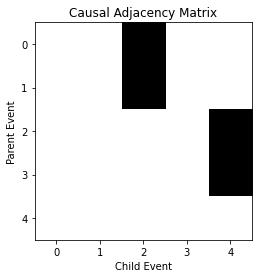

In [4]:
ids = list(H.events.keys())
index = {eid:i for i,eid in enumerate(ids)}
A = np.zeros((len(ids), len(ids)))

for e in H.events.values():
    for p in e.parents:
        A[index[p], index[e.eid]] = 1

plt.figure(figsize=(4,4))
plt.imshow(A, cmap='gray_r')
plt.title('Causal Adjacency Matrix')
plt.xlabel('Child Event')
plt.ylabel('Parent Event')
plt.show()


## Visualization: Event Similarity Embedding

Events are embedded based on overlap of causal ancestry. Events with similar
lineages appear closer together.

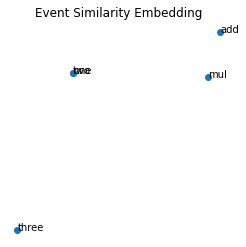

In [5]:
def ancestry_set(eid):
    return set(H.lineage(eid))

sets = [ancestry_set(eid) for eid in ids]
D = np.zeros((len(ids), len(ids)))

for i in range(len(ids)):
    for j in range(len(ids)):
        inter = len(sets[i] & sets[j])
        union = len(sets[i] | sets[j])
        D[i,j] = 1 - inter/union if union else 0

# simple 2D projection
X = np.linalg.svd(D)[0][:,:2]

plt.figure(figsize=(4,4))
plt.scatter(X[:,0], X[:,1])
for i,eid in enumerate(ids):
    plt.text(X[i,0], X[i,1], H.events[eid].label)
plt.title('Event Similarity Embedding')
plt.axis('off')
plt.show()


## Visualization: Causal Growth Curve

This plot shows cumulative growth of the event ledger as irreversible
computation proceeds.

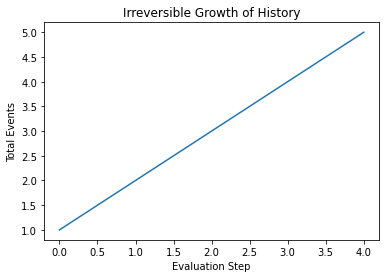

In [6]:
sizes = list(range(1, len(H.events)+1))
plt.figure()
plt.plot(sizes)
plt.xlabel('Evaluation Step')
plt.ylabel('Total Events')
plt.title('Irreversible Growth of History')
plt.show()


## Causal Adjacency Matrix

The event history is represented as an adjacency matrix encoding direct
parent–child relations. This provides a linear-algebraic view of causal
structure independent of any geometric embedding.

Rows correspond to parent events and columns correspond to child events.


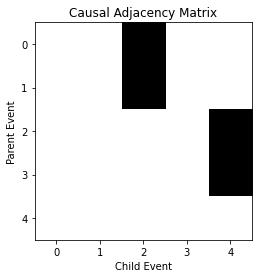

In [7]:
import numpy as np

ids = list(H.events.keys())
index = {eid: i for i, eid in enumerate(ids)}

A = np.zeros((len(ids), len(ids)))
for e in H.events.values():
    for p in e.parents:
        A[index[p], index[e.eid]] = 1

plt.figure(figsize=(4,4))
plt.imshow(A, cmap="gray_r")
plt.xlabel("Child Event")
plt.ylabel("Parent Event")
plt.title("Causal Adjacency Matrix")
plt.show()


## Spectral Decomposition of the Causal Graph

The eigenvalues of the adjacency matrix provide a spectral characterization
of the causal structure. This view highlights global structural modes that
are not apparent in direct graph visualizations.


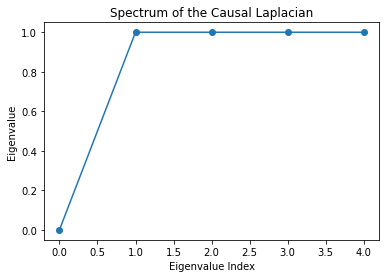

In [10]:
# degree matrix (out-degree)
D = np.diag(A.sum(axis=1))

# graph Laplacian
L = D - A

eigs_L = np.linalg.eigvals(L)

plt.figure()
plt.plot(np.sort(np.real(eigs_L)), marker="o")
plt.title("Spectrum of the Causal Laplacian")
plt.xlabel("Eigenvalue Index")
plt.ylabel("Eigenvalue")
plt.show()


## Event Similarity Embedding

Events are embedded in a low-dimensional space based on overlap of their
causal ancestry. Events with similar lineages appear closer together in
this representation.

This provides a geometric view of semantic proximity.


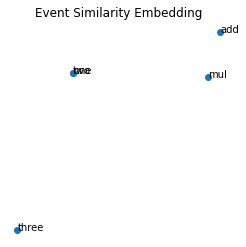

In [9]:
def ancestry_set(eid):
    return set(H.lineage(eid))

sets = [ancestry_set(eid) for eid in ids]

D = np.zeros((len(ids), len(ids)))
for i in range(len(ids)):
    for j in range(len(ids)):
        inter = len(sets[i] & sets[j])
        union = len(sets[i] | sets[j])
        D[i, j] = 1 - inter / union if union else 0

# simple 2D embedding via SVD
X = np.linalg.svd(D)[0][:, :2]

plt.figure(figsize=(4,4))
plt.scatter(X[:,0], X[:,1])
for i, eid in enumerate(ids):
    plt.text(X[i,0], X[i,1], H.events[eid].label)
plt.title("Event Similarity Embedding")
plt.axis("off")
plt.show()
